# Notebook for visualizing MVP phase 2 coherence check results

Coherence check includes results generated by FastQC, Samtools Flagstat, and RTG Vcfstats.

In [1]:
from io import StringIO

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import google.datalab.bigquery as bq

# MVP FastQC Results (n= )

### Bigquery table

In [2]:
mvp_fastqc_table="gbsc-gcp-project-mvp.testing.Jina_Personalis_fastqc_tar"

## Total read sequence

In [3]:
per_sample_totseq = bq.Query('SELECT sample, ' +
                  'SUM(CAST(value as INT64)) AS totseq ' +
                  'FROM `' + mvp_fastqc_table + '` ' +
                  'WHERE dimension = "total_seq" ' +
                  'GROUP BY sample').execute().result().to_dataframe()
per_sample_totseq.head()

,sample,totseq
0,SHIP4421010,814669866
1,SHIP4421025,1029374570
2,SHIP4421054,900416233
3,SHIP4421058,973032971
4,SHIP4421060,787444094


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


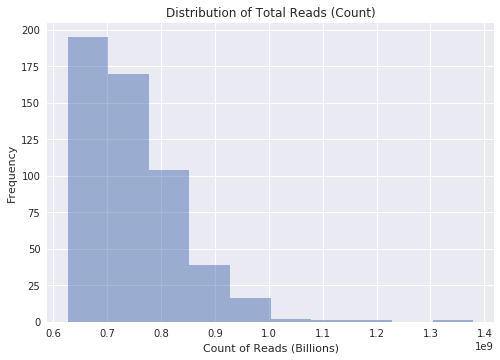

In [4]:
fig, ax = plt.subplots()
hist = per_sample_totseq.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Total Reads (Count)")
ax.set_xlabel("Count of Reads (Billions)")
ax.set_ylabel("Frequency")
plt.show()

## Per base quality

Inserted aggregation function (Average) for per base quality of each sample based on the FastQC results of 25 chromosomes

In [5]:
per_base_qual = bq.Query('SELECT index, value_tenth, ' +
                         'COUNT(*) AS observations ' +
                         'FROM (SELECT sample, index, ' +
                         'ROUND(AVG(CAST(value AS FLOAT64)), 1) AS value_tenth ' +
                         'FROM `' + mvp_fastqc_table + '` ' +
                         'WHERE dimension = "per_base_qual" ' +
                         'GROUP BY sample, index) ' +
                         'GROUP BY index, value_tenth').execute().result().to_dataframe()
#per_base_qual.head()

Divided start point and end point of base quality index  <br />
Changed data type from string to num  <br />
Added log_observation

In [6]:
start_end = pd.DataFrame(per_base_qual['index'].str.split('-',1).tolist(), columns=['start', 'end'])
per_base_qual = per_base_qual.join(start_end)

per_base_qual[['value_tenth']] = per_base_qual[['value_tenth']].apply(pd.to_numeric)
per_base_qual[['start']] = per_base_qual[['start']].apply(pd.to_numeric)
per_base_qual[['observations']] = per_base_qual[['observations']].apply(pd.to_numeric)

per_base_qual[['log_observations']] = np.log(per_base_qual[['observations']])
per_base_qual.head()

,index,value_tenth,observations,start,end,log_observations
0,1,28.3,1,1,None,0.0
1,2,30.2,1,2,None,0.0
2,2,28.1,1,2,None,0.0
3,2,27.8,1,2,None,0.0
4,3,29.8,1,3,None,0.0


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


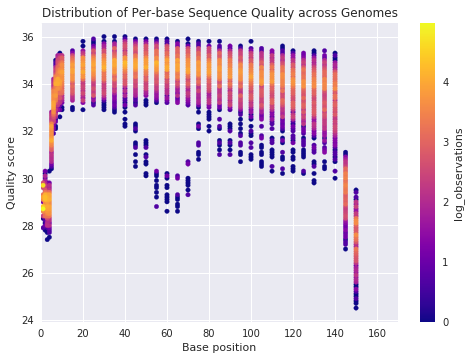

In [7]:
fig, ax = plt.subplots()
scat = per_base_qual.plot(kind='scatter', x='start', y='value_tenth', c='log_observations', cmap='plasma', ax=ax)
ax.set_xlim(0,170)
ax.set_title("Distribution of Per-base Sequence Quality across Genomes")
ax.set_xlabel("Base position")
ax.set_ylabel("Quality score")
plt.show()

## GC Content

gc_content value

In [8]:
dimension = "gc_content"
gc_content_pre = bq.Query('SELECT sample, chr, CAST(value as INT64) AS GC_value ' +
                      'FROM `' + mvp_fastqc_table + '` ' +
                      'WHERE dimension = "' + dimension + '"' ).execute().result().to_dataframe()
gc_content_pre.head()

,sample,chr,GC_value
0,SHIP4475811,chromosome_Y,35
1,SHIP4447245,chromosome_Y,36
2,SHIP4449637,chromosome_Y,36
3,SHIP4599970,chromosome_Y,36
4,SHIP4600185,chromosome_Y,36


read count of each chromosome

In [9]:
dimension = "total_seq"
seq_pre = bq.Query('SELECT sample, chr, CAST(value as INT64) AS seq_value ' +
                      'FROM `' + mvp_fastqc_table + '` ' +
                      'WHERE dimension = "' + dimension + '"' ).execute().result().to_dataframe()
seq_pre.head()

,sample,chr,seq_value
0,SHIP4421010,chromosome_1,66609235
1,SHIP4421025,chromosome_1,84030933
2,SHIP4421054,chromosome_1,73365518
3,SHIP4421058,chromosome_1,79421858
4,SHIP4421060,chromosome_1,63007492


join read count of each chromosome and total read count in a sample

In [10]:
seq_tot_pre=seq_pre.set_index('sample').join(per_sample_totseq.set_index('sample'))
seq_tot_pre=seq_tot_pre.reset_index()
seq_tot_pre.head()

,sample,chr,seq_value,totseq
0,SHIP4421010,chromosome_1,66609235,814669866
1,SHIP4421010,chromosome_2,70614441,814669866
2,SHIP4421010,chromosome_3,55930223,814669866
3,SHIP4421010,chromosome_4,53721678,814669866
4,SHIP4421010,chromosome_5,51208502,814669866


join GC value

In [11]:
gc_seq_tot_pre=seq_tot_pre.set_index(['sample','chr']).join(gc_content_pre.set_index(['sample','chr']))
gc_seq_tot_pre=gc_seq_tot_pre.reset_index()
gc_seq_tot_pre.head()

,sample,chr,seq_value,totseq,GC_value
0,SHIP4421010,chromosome_1,66609235,814669866,42
1,SHIP4421010,chromosome_2,70614441,814669866,41
2,SHIP4421010,chromosome_3,55930223,814669866,40
3,SHIP4421010,chromosome_4,53721678,814669866,38
4,SHIP4421010,chromosome_5,51208502,814669866,39


chr-gc-value affecting the sample-gc-value : GC_value * (seq_value / totseq)

In [12]:
gc_seq_tot_pre[['seq_value','totseq']] = gc_seq_tot_pre[['seq_value','totseq']].apply(pd.to_numeric)
gc_seq_tot_pre['GC_ratio'] = gc_seq_tot_pre['GC_value']*(gc_seq_tot_pre['seq_value']/gc_seq_tot_pre['totseq'])
gc_seq_tot_pre.head()

,sample,chr,seq_value,totseq,GC_value,GC_ratio
0,SHIP4421010,chromosome_1,66609235,814669866,42,3.434014
1,SHIP4421010,chromosome_2,70614441,814669866,41,3.553822
2,SHIP4421010,chromosome_3,55930223,814669866,40,2.746154
3,SHIP4421010,chromosome_4,53721678,814669866,38,2.505829
4,SHIP4421010,chromosome_5,51208502,814669866,39,2.451461


sum chr-gc-value for per sample

In [13]:
gc_content = gc_seq_tot_pre.groupby(['sample'])['GC_ratio'].sum()
gc_content = gc_content.to_frame()
gc_content = gc_content.reset_index()
gc_content = gc_content.round(1)
gc_content.head()

,sample,GC_ratio
0,SHIP4421010,41.0
1,SHIP4421025,40.9
2,SHIP4421054,41.0
3,SHIP4421058,41.0
4,SHIP4421060,40.9


frequency of GC-value

In [14]:
gc_content_counts = gc_content.groupby('GC_ratio')['sample'].count()
print (gc_content_counts)

GC_ratio
40.1      4
40.2      2
40.3      6
40.4     17
40.5     39
40.6     56
40.7    160
40.8     92
40.9     51
41.0     86
41.1     10
41.2      5
41.3      1
Name: sample, dtype: int64


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


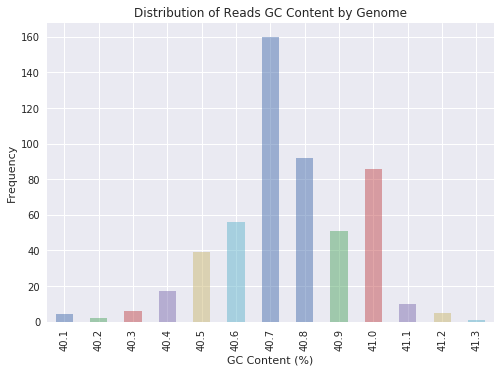

In [15]:
fig, ax = plt.subplots()
bar = gc_content_counts.plot.bar(alpha=0.5)
ax.set_title("Distribution of Reads GC Content by Genome")
ax.set_xlabel("GC Content (%)")
ax.set_ylabel("Frequency")
plt.show()

## Average sequence quality

sum seq_quality

In [16]:
dimension = "seq_quality"
avg_seq_qual = bq.Query('SELECT sample, ' +
                        'SUM(CAST(index as INT64) * CAST(value AS FLOAT64))/SUM(CAST(value AS FLOAT64)) ' +
                        'FROM `' + mvp_fastqc_table + '` ' +
                        'WHERE dimension = "' + dimension + '" ' +
                        'GROUP BY sample').execute().result().to_dataframe()
avg_seq_qual.head()

,sample,f0_
0,SHIP4421010,33.240945
1,SHIP4421025,33.735155
2,SHIP4421054,33.363365
3,SHIP4421058,33.277378
4,SHIP4421060,32.743709


In [25]:
#plt.figure()
#plt.boxplot(avg_seq_qual['f0_'], 0, 'gD')
#plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


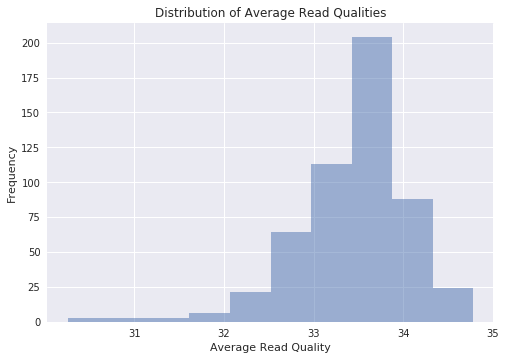

In [17]:
fig, ax = plt.subplots()
avg_seq_qual.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Average Read Qualities")
ax.set_xlabel("Average Read Quality")
ax.set_ylabel("Frequency")
plt.show()

## Sequence length

In [18]:
dimension = "seq_len"
seq_len = bq.Query('SELECT sample, dimension, ' +
                   'CAST(value AS INT64) as value ' + 
                   'FROM `' + mvp_fastqc_table + '` ' + 
                   'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
seq_len.head()

,sample,dimension,value
0,SHIP4421010,seq_len,150
1,SHIP4421010,seq_len,150
2,SHIP4421010,seq_len,150
3,SHIP4421010,seq_len,150
4,SHIP4421010,seq_len,150


In [19]:
seq_len_counts = seq_len.groupby('value')['sample'].nunique()
print (seq_len_counts)

value
150    529
Name: sample, dtype: int64


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


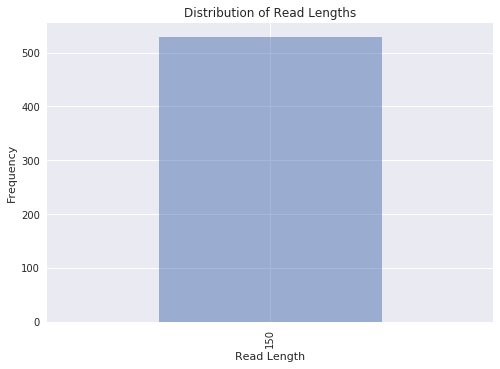

In [20]:
fig, ax = plt.subplots()
bar = seq_len_counts.plot.bar(alpha=0.5)
ax.set_title("Distribution of Read Lengths")
ax.set_xlabel("Read Length")
ax.set_ylabel("Frequency")
plt.show()

# MVP Phase 2 VCFStats Results (n=1902)

### Bigquery table

In [2]:
mvp_vcfstats_table = "gbsc-gcp-project-mvp.testing.Jina_Personalis_vcfstats_tar"

## SNPs per genome

In [3]:
snps = bq.Query('SELECT sample, dimension, ' +
                'CAST(value AS INT64) as value ' +
                'FROM `' + mvp_vcfstats_table + '` ' +
                'WHERE dimension = "snps" ').execute().result().to_dataframe()
snps.head()

,sample,dimension,value
0,SHIP4423287,snps,3536545
1,SHIP4481743,snps,3549121
2,SHIP4488265,snps,3553512
3,SHIP4432949,snps,3555789
4,SHIP4454546,snps,3561081


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


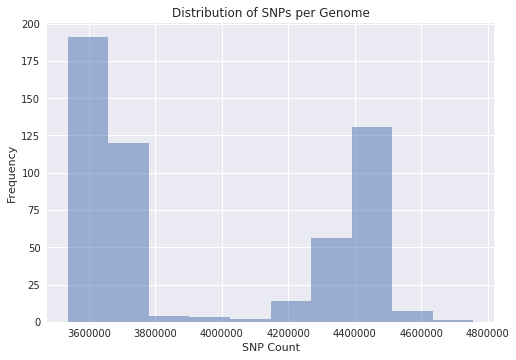

In [4]:
fig, ax = plt.subplots()
hist = snps.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of SNPs per Genome")
ax.set_xlabel("SNP Count")
ax.set_ylabel("Frequency")
plt.show()

## Check number of variants in each category
I am not sure whether RTG Tools vcfstats considers failed variants, and their documentation of vcfstats is very poor. Eye-check of ~10 vcfstats files does not show any variants marked as "Failed Filters".

I'm going to run a query to see if any were marked as failing.

In [5]:
dimension_sums = bq.Query('SELECT dimension, SUM(CAST(value AS INT64)) AS sum ' +
                'FROM `' + mvp_vcfstats_table + '` ' +
                'WHERE dimension IN ("failed_filters", "passed_filters") ' +
                'GROUP BY dimension').execute().result().to_dataframe()
dimension_sums.head()

,dimension,sum
0,failed_filters,103948643
1,passed_filters,2590342233


## Indels per genome

In [6]:
dimension1 = "indels"
dimension2 = "insertions"
dimension3 = "deletions"

indels = bq.Query('SELECT sample, ' +
                  'SUM(CAST(value AS INT64)) as value ' +
                  'FROM `' + mvp_vcfstats_table + '` ' +
                  'WHERE (dimension = "' + dimension1 + '") OR (dimension = "' + dimension2 + '") OR (dimension = "' + dimension3 + '")' +
                  'GROUP BY sample').execute().result().to_dataframe()
indels.head()

,sample,value
0,SHIP4449463,862976
1,SHIP4599405,1057537
2,SHIP4447108,897537
3,SHIP4432927,880386
4,SHIP4473256,904450


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


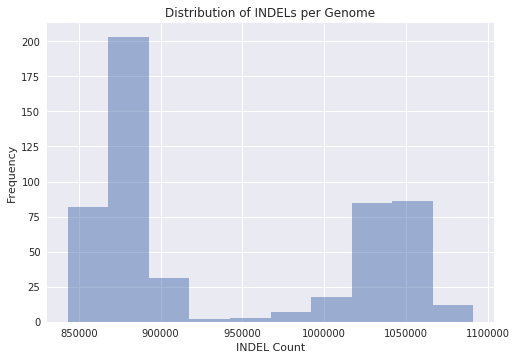

In [7]:
fig, ax = plt.subplots()
hist = indels.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of INDELs per Genome")
ax.set_xlabel("INDEL Count")
ax.set_ylabel("Frequency")
plt.show()

In [32]:
#box = indels.plot.box()

In [33]:
#plt.figure()
#plt.boxplot(indels['value'], 0, 'gD')
#plt.show()

## Cumulative insertions, deletions, and indels
RTG Tools vcfstats outputs data on three categories of indels: insertions, deletions, and indels. From this google group post (https://groups.google.com/a/realtimegenomics.com/forum/#!searchin/rtg-users/vcfstats/rtg-users/-eFsSbWF6ks/1HrnevHTAgAJ):

>For the insertions/deletions/indels the table is based on the delta in length rather than total length (which really matters for the indels):

>Insertions (pure addition of bases)
>A -> AT (length 1 insertion)
>ATT -> ATTTT (length 2 insertion) 

>Deletions (pure deletion of bases)
>AT -> A (length 1 deletion)
>ATTTT -> ATT (length 2 deletion)

>Indels (length changing but not pure)
>ATT -> CTTT (length 1 indel)
>CTTT -> ATT (length 1 indel)"

In [8]:
indels = bq.Query('SELECT sample, SUM(DISTINCT CAST(value AS INT64)) AS cum_indels ' +
                  'FROM `' + mvp_vcfstats_table + '` ' +
                  'WHERE dimension = "insertions" ' +
                  'OR dimension = "deletions" ' +
                  'OR dimension = "indels" ' +
                  'GROUP BY sample').execute().result().to_dataframe()
indels.head()

,sample,cum_indels
0,SHIP4449463,862976
1,SHIP4599405,1057537
2,SHIP4447108,897537
3,SHIP4432927,880386
4,SHIP4473256,904450


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


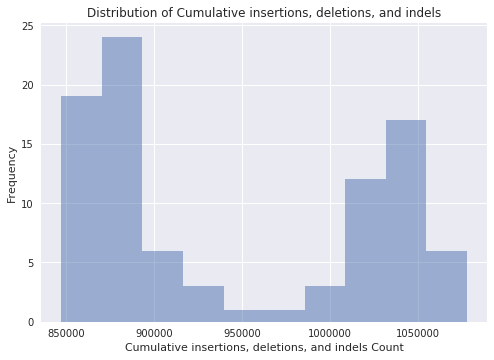

In [42]:
fig, ax = plt.subplots()
hist = indels.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Cumulative insertions, deletions, and indels")
ax.set_xlabel("Cumulative insertions, deletions, and indels Count")
ax.set_ylabel("Frequency")
plt.show()

## Frequency of Ti/Tv ratios

In [9]:
dimension = "ti_tv_ratio"
ti_tv = bq.Query('SELECT sample, dimension, ' + 
                 'CAST(value AS FLOAT64) as value ' + 
                 'FROM `' + mvp_vcfstats_table + '` ' + 
                 'WHERE dimension = "' + dimension + '"').execute().result().to_dataframe()
ti_tv.head()

,sample,dimension,value
0,SHIP4423460,ti_tv_ratio,2.04
1,SHIP4423478,ti_tv_ratio,2.04
2,SHIP4425270,ti_tv_ratio,2.04
3,SHIP4432883,ti_tv_ratio,2.04
4,SHIP4436609,ti_tv_ratio,2.04


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


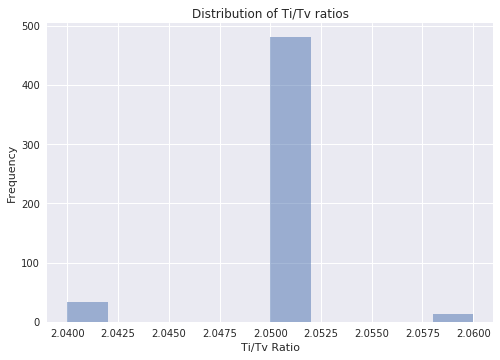

In [10]:
fig, ax = plt.subplots()
hist = ti_tv.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Ti/Tv ratios")
ax.set_xlabel("Ti/Tv Ratio")
ax.set_ylabel("Frequency")
plt.show()

In [45]:
#plt.figure()
#plt.boxplot(ti_tv['value'], 0, 'gD')
#plt.show()

## Frequency of SNP het/hom ratios

In [11]:
snp_het_hom_ratio = bq.Query('SELECT sample, dimension, ' + 
                             'CAST(value AS FLOAT64) as value ' + 
                             'FROM `' + mvp_vcfstats_table + '` ' + 
                             'WHERE dimension = "snp_het_hom_ratio"').execute().result().to_dataframe()
snp_het_hom_ratio.head()

,sample,dimension,value
0,SHIP4600180,snp_het_hom_ratio,1.36
1,SHIP4481743,snp_het_hom_ratio,1.46
2,SHIP4449629,snp_het_hom_ratio,1.47
3,SHIP4454554,snp_het_hom_ratio,1.47
4,SHIP4432949,snp_het_hom_ratio,1.48


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


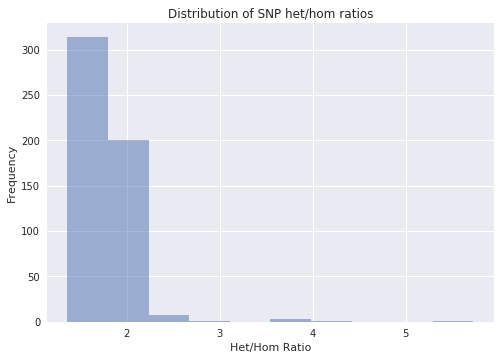

In [12]:
fig, ax = plt.subplots()
hist = snp_het_hom_ratio.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of SNP het/hom ratios")
ax.set_xlabel("Het/Hom Ratio")
ax.set_ylabel("Frequency")
plt.show()

# MVP Phase 2 Samtools Flagstat Results (n=1902)

In [13]:
mvp_flagstat_table = "gbsc-gcp-project-mvp.testing.Jina_Personalis_flagstat_tar"

## Count and Percent of reads mapped to reference

In [14]:
dimension = "qc_passed_reads_count"
qc_passed_reads_count = bq.Query('SELECT sample, ' + 
                             'SUM(CAST(value AS FLOAT64)) as total_count ' + 
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"' +
                             'GROUP BY sample, dimension').execute().result().to_dataframe()

In [15]:
dimension = "mapped_reads_count"
mapped_reads_count = bq.Query('SELECT sample, ' + 
                             'SUM(CAST(value AS FLOAT64)) as mapped_count ' + 
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"' +
                             'GROUP BY sample, dimension').execute().result().to_dataframe()

In [16]:
mapped_reads_perc=qc_passed_reads_count.set_index(['sample']).join(mapped_reads_count.set_index(['sample']))
mapped_reads_perc['mapped_perc']=100*(mapped_reads_perc['mapped_count']/mapped_reads_perc['total_count'])
mapped_reads_perc['total_count']=mapped_reads_perc.total_count.astype(int)
mapped_reads_perc['mapped_count']=mapped_reads_perc.mapped_count.astype(int)
mapped_reads_perc['mapped_perc']=mapped_reads_perc.mapped_perc.astype(float).round(2)
mapped_reads_perc.head()

,total_count,mapped_count,mapped_perc
sample,,,
SHIP4599402,832395597,831613208,99.91
SHIP4599954,931057129,930104724,99.90
SHIP4423297,814103226,813357739,99.91
SHIP4558881,842782833,841929049,99.90
SHIP4423434,684283983,683748177,99.92


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


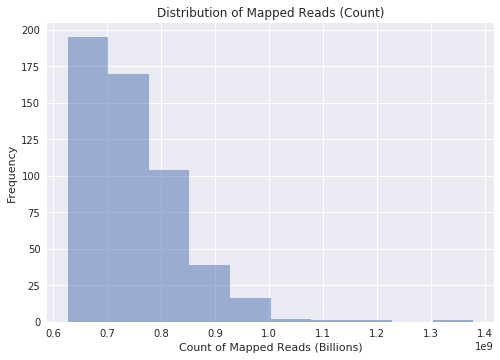

In [17]:
fig, ax = plt.subplots()
hist = mapped_reads_perc.mapped_count.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Mapped Reads (Count)")
ax.set_xlabel("Count of Mapped Reads (Billions)")
ax.set_ylabel("Frequency")
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


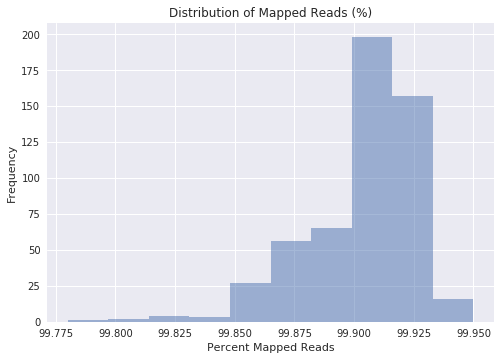

In [18]:
fig, ax = plt.subplots()
hist = mapped_reads_perc.mapped_perc.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Mapped Reads (%)")
ax.set_xlabel("Percent Mapped Reads")
ax.set_ylabel("Frequency")
plt.show()

## Count and Percent of reads properly paired

In [19]:
dimension = "properly_paired_count"
properly_paired_count = bq.Query('SELECT sample, ' + 
                             'SUM(CAST(value AS FLOAT64)) as mapped_count ' + 
                             'FROM `' + mvp_flagstat_table + '` ' + 
                             'WHERE dimension = "' + dimension + '"' +
                             'GROUP BY sample, dimension').execute().result().to_dataframe()

In [20]:
properly_paired_perc=qc_passed_reads_count.set_index(['sample']).join(properly_paired_count.set_index(['sample']))
properly_paired_perc['mapped_perc']=100*(properly_paired_perc['mapped_count']/properly_paired_perc['total_count'])
properly_paired_perc['total_count']=properly_paired_perc.total_count.astype(int)
properly_paired_perc['mapped_count']=properly_paired_perc.mapped_count.astype(int)
properly_paired_perc['mapped_perc']=properly_paired_perc.mapped_perc.astype(float).round(2)
properly_paired_perc.head()

,total_count,mapped_count,mapped_perc
sample,,,
SHIP4599402,832395597,808921789,97.18
SHIP4599954,931057129,917922200,98.59
SHIP4423297,814103226,798631471,98.10
SHIP4558881,842782833,830080114,98.49
SHIP4423434,684283983,672650548,98.30


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


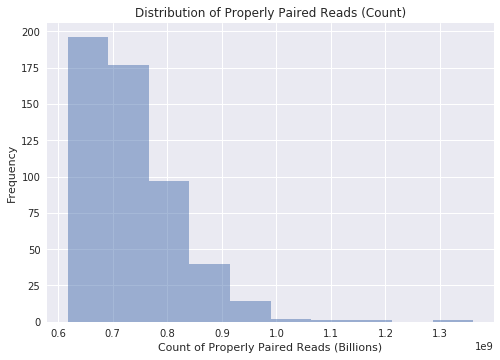

In [21]:
fig, ax = plt.subplots()
hist = properly_paired_perc.mapped_count.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (Count)")
ax.set_xlabel("Count of Properly Paired Reads (Billions)")
ax.set_ylabel("Frequency")
plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


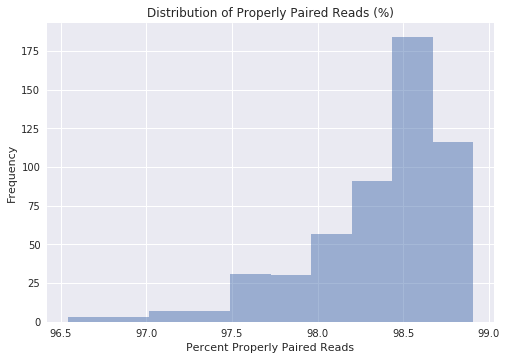

In [22]:
fig, ax = plt.subplots()
hist = properly_paired_perc.mapped_perc.hist(alpha=0.5, ax=ax)
ax.set_title("Distribution of Properly Paired Reads (%)")
ax.set_xlabel("Percent Properly Paired Reads")
ax.set_ylabel("Frequency")
plt.show()